In [1]:
# Cell 1: Libraries and Settings
# Imports
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '' # this line ignore the GPU
import re
import random
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import time

# Paths
PREPROC_ROOT = Path('preprocessed_variants_2')
RESULTS_DIR = Path('models_results_2')
MODELS_DIR = Path('models_2')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Settings
SEED = 42
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 40

# Tomato Classes
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(SEED)

In [2]:
# Cell 2 Helpers - Base Model
def build_base_model(input_shape=(50,50,3), n_classes=10, use_gap=True, bn=True, dropout=0.4):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    if use_gap:
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)

    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

In [3]:
# Cell 3: Utilities

# Parsing and reading
def parse_variant_name(variant_name: str):
    # look for numeric groups number X number ... followed by quality number at the end
    m = re.search(r"(\d+)[xX](\d+).*?(\d+)$", variant_name)
    if m:
        w = int(m.group(1)); h = int(m.group(2)); q = int(m.group(3))
        return (w,h), q
    # fallback
    return (50,50), None

# split data in Val, test and train
def create_splits_for_variant(variant_path: Path, seed=SEED, train_frac=0.6, val_frac=0.2, test_frac=0.2, extensions=(".jpg",)):
    rng = np.random.default_rng(seed)
    rows = []
    train_paths, val_paths, test_paths = [], [], []
    class_folders = sorted([d for d in variant_path.iterdir() if d.is_dir()])

    for cls_folder in class_folders:
        files = sorted([p for p in cls_folder.glob("*") if p.suffix.lower() in extensions])
        n = len(files)
        if n == 0:
            continue
        idx = rng.permutation(n)
        n_train = int(np.floor(train_frac * n))
        n_val = int(np.floor(val_frac * n))
        # set train, val, test in permutations order
        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train+n_val]
        test_idx = idx[n_train+n_val:]
        for i in train_idx:
            train_paths.append(files[i])
            rows.append({"filepath": str(files[i]), "class": cls_folder.name, "split": "train"})
        for i in val_idx:
            val_paths.append(files[i])
            rows.append({"filepath": str(files[i]), "class": cls_folder.name, "split": "val"})
        for i in test_idx:
            test_paths.append(files[i])
            rows.append({"filepath": str(files[i]), "class": cls_folder.name, "split": "test"})

    # save CSV for tracking
    splits_df = pd.DataFrame(rows)
    splits_csv = RESULTS_DIR / f"splits_{variant_path.name}.csv"
    splits_df.to_csv(splits_csv, index=False)
    return train_paths, val_paths, test_paths, list(map(lambda d: d.name, class_folders)), splits_csv

# To Build tf.data from paths list
def paths_to_dataset(file_paths, labels, image_size=(50,50), batch_size=32, shuffle=False, seed=SEED):
    file_paths = [str(p) for p in file_paths]
    labels = np.array(labels, dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    def _load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)  # decode
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        # ensure size (images are preprocessed but we keep this safeguard)
        img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BICUBIC)
        return img, label

    ds = ds.map(_load_image, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=seed)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds


# Compute metrics 
def compute_metrics_from_preds(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'confusion_matrix': cm}



In [4]:
# Main Loop on variants
variants_folders = sorted([p for p in PREPROC_ROOT.iterdir() if p.is_dir()])
print(f"Found {len(variants_folders)} variants\n")

results = []

for variant_path in variants_folders:
    variant_name = variant_path.name
    print(f"\n=== Running variant: {variant_name} ===")
    # parse
    image_size, quality = parse_variant_name(variant_name)
    # cap quality si es > 100 (precaución)
    if quality is not None and quality > 100:
        print(f"Quality {quality} > 100 detected. Capping to 95 for safety.")
        quality = 95

    # create splits estratificaded by class (it save in CSV)
    train_paths, val_paths, test_paths, class_names_on_disk, splits_csv = create_splits_for_variant(variant_path, seed=SEED)
    n_train = len(train_paths); n_val = len(val_paths); n_test = len(test_paths)
    print(f"Counts (train/val/test): {n_train} / {n_val} / {n_test}")
    if len(class_names_on_disk) == 0:
        print("WARNING: No class folders found for variant", variant_name)
        continue

    # map class name -> label index (deterministic order based on class_names_on_disk)
    class_to_index = {name: idx for idx, name in enumerate(class_names_on_disk)}
    n_classes = len(class_names_on_disk)
    print("Classes:", class_names_on_disk)

    # Build label arrays (extract class from path.parent.name)
    def _paths_to_labels(paths_list):
        labels = []
        for p in paths_list:
            parent = Path(p).parent.name
            labels.append(class_to_index[parent])
        return labels

    train_labels = _paths_to_labels(train_paths)
    val_labels = _paths_to_labels(val_paths)
    test_labels = _paths_to_labels(test_paths)

    # create tf.data datasets
    train_ds = paths_to_dataset(train_paths, train_labels, image_size=image_size, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
    val_ds = paths_to_dataset(val_paths, val_labels, image_size=image_size, batch_size=BATCH_SIZE, shuffle=False)
    test_ds = paths_to_dataset(test_paths, test_labels, image_size=image_size, batch_size=BATCH_SIZE, shuffle=False)

    # build model
    set_seed(SEED)
    model = build_base_model(input_shape=(image_size[0], image_size[1], 3), n_classes=n_classes, use_gap=True, bn=True, dropout=0.4)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks
    ckpt_path = MODELS_DIR / f"{variant_name}__best.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(str(ckpt_path), monitor='val_loss', save_best_only=True, save_weights_only=False)
    ]

    # Training with train + val
    start_time = time.perf_counter()
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=2)
    end_train = time.perf_counter()
    train_time = round(end_train - start_time, 2)

    # Final evaluation in test set
    print("Computing final metrics on TEST set...")
    # predecir todo en test_ds (vectorizado)
    preds = model.predict(test_ds, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    # Build and read y_true in same order (test_ds está batched)
    y_true = []
    for _, yb in test_ds:
        y_true.extend(yb.numpy().tolist())
    y_true = np.array(y_true)
    y_pred = np.array(pred_labels)

    metrics = compute_metrics_from_preds(y_true, y_pred)
    print("Test F1 macro:", metrics['f1'])

    # save results
    record = {
        'variant': variant_name,
        'image_size': f"{image_size[0]}x{image_size[1]}",
        'quality': quality,
        'n_classes': n_classes,
        'train_images': n_train,
        'val_images': n_val,
        'test_images': n_test,
        'train_epochs': len(history.history['loss']),
        'train_time_seconds': train_time,
        'test_accuracy': metrics['accuracy'],
        'test_precision_macro': metrics['precision'],
        'test_recall_macro': metrics['recall'],
        'test_f1_macro': metrics['f1'],
        'checkpoint_path': str(ckpt_path),
        'splits_csv': str(splits_csv)
    }
    results.append(record)

    # Save history & confusion matrix
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(RESULTS_DIR / f"history_{variant_name}.csv", index=False)
    np.save(RESULTS_DIR / f"cm_{variant_name}.npy", metrics['confusion_matrix'])

    # free memory
    del model
    tf.keras.backend.clear_session()

# Save summary results
results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_DIR / 'general_comparison.csv', index=False)
print('\nAll variants processed. Results saved to', RESULTS_DIR / 'general_comparison.csv')

Found 8 variants


=== Running variant: resolution_50X50_quality_50 ===
Counts (train/val/test): 10891 / 3628 / 3640
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 24s - 71ms/step - accuracy: 0.6649 - loss: 1.1839 - val_accuracy: 0.3222 - val_loss: 3.4617 - learning_rate: 0.0010
Epoch 2/40
341/341 - 12s - 36ms/step - accuracy: 0.6235 - loss: 1.3153 - val_accuracy: 0.3013 - val_loss: 5.7646 - learning_rate: 0.0010
Epoch 3/40
341/341 - 13s - 37ms/step - accuracy: 0.6254 - loss: 1.1976 - val_accuracy: 0.3026 - val_loss: 9.4518 - learning_rate: 0.0010
Epoch 4/40
341/341 - 12s - 36ms/step - accuracy: 0.6191 - loss: 1.1558 - val_accuracy: 0.3026 - val_loss: 4.1488 - learning_rate: 0.0010
Epoch 5/40
341/341 - 13s - 37ms/step - accuracy: 0.5562 - loss: 1.3157 - val_accuracy: 0.3324 - val_loss: 3.9341 - learning_rate: 5.0000e-04
Epoch 6/40
341/341 - 13s - 39ms/step - accuracy: 0.5621 - loss: 1.2764 - val_accuracy: 0.3280 - val_loss: 3.8833 - learning_rate: 5.0000e-04
Epoch 7/40
341/341 - 12s - 36ms/step - accuracy: 0.5878 - loss: 1.1978 - val_accuracy: 0.3332 - val_loss: 3.9223 - learning_rate: 5.0000e-04
Computing final metrics on TEST set...
T


=== Running variant: resolution_50X50_quality_70 ===
Counts (train/val/test): 10891 / 3628 / 3640
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 23s - 69ms/step - accuracy: 0.6582 - loss: 1.1999 - val_accuracy: 0.2952 - val_loss: 5.3521 - learning_rate: 0.0010
Epoch 2/40
341/341 - 13s - 38ms/step - accuracy: 0.6219 - loss: 1.2940 - val_accuracy: 0.2958 - val_loss: 5.8718 - learning_rate: 0.0010
Epoch 3/40
341/341 - 13s - 39ms/step - accuracy: 0.6312 - loss: 1.1742 - val_accuracy: 0.2980 - val_loss: 6.4620 - learning_rate: 0.0010
Epoch 4/40


341/341 - 13s - 39ms/step - accuracy: 0.6416 - loss: 1.1150 - val_accuracy: 0.3225 - val_loss: 4.3906 - learning_rate: 0.0010
Epoch 5/40
341/341 - 13s - 38ms/step - accuracy: 0.6505 - loss: 1.0637 - val_accuracy: 0.2952 - val_loss: 7.5282 - learning_rate: 0.0010
Epoch 6/40
341/341 - 13s - 38ms/step - accuracy: 0.6413 - loss: 1.0962 - val_accuracy: 0.2963 - val_loss: 9.0501 - learning_rate: 0.0010
Epoch 7/40


341/341 - 13s - 37ms/step - accuracy: 0.6457 - loss: 1.0511 - val_accuracy: 0.3906 - val_loss: 4.3672 - learning_rate: 0.0010
Epoch 8/40
341/341 - 12s - 36ms/step - accuracy: 0.6650 - loss: 1.0204 - val_accuracy: 0.3120 - val_loss: 5.7501 - learning_rate: 0.0010
Epoch 9/40
341/341 - 13s - 37ms/step - accuracy: 0.6528 - loss: 1.0509 - val_accuracy: 0.3162 - val_loss: 4.7167 - learning_rate: 0.0010
Epoch 10/40
341/341 - 13s - 37ms/step - accuracy: 0.6302 - loss: 1.0895 - val_accuracy: 0.3258 - val_loss: 6.4969 - learning_rate: 0.0010
Epoch 11/40


341/341 - 13s - 38ms/step - accuracy: 0.5401 - loss: 1.3352 - val_accuracy: 0.3997 - val_loss: 3.6392 - learning_rate: 5.0000e-04
Epoch 12/40


341/341 - 13s - 39ms/step - accuracy: 0.5771 - loss: 1.2305 - val_accuracy: 0.3889 - val_loss: 2.6336 - learning_rate: 5.0000e-04
Epoch 13/40


341/341 - 13s - 38ms/step - accuracy: 0.6074 - loss: 1.1666 - val_accuracy: 0.3718 - val_loss: 2.4742 - learning_rate: 5.0000e-04
Epoch 14/40
341/341 - 13s - 39ms/step - accuracy: 0.6111 - loss: 1.1442 - val_accuracy: 0.4079 - val_loss: 3.4766 - learning_rate: 5.0000e-04
Epoch 15/40
341/341 - 14s - 41ms/step - accuracy: 0.5969 - loss: 1.1663 - val_accuracy: 0.3556 - val_loss: 4.2579 - learning_rate: 5.0000e-04
Epoch 16/40
341/341 - 14s - 42ms/step - accuracy: 0.6034 - loss: 1.1618 - val_accuracy: 0.3746 - val_loss: 3.4250 - learning_rate: 5.0000e-04
Epoch 17/40


341/341 - 13s - 39ms/step - accuracy: 0.5325 - loss: 1.3828 - val_accuracy: 0.4498 - val_loss: 1.7708 - learning_rate: 2.5000e-04
Epoch 18/40


341/341 - 12s - 37ms/step - accuracy: 0.5520 - loss: 1.2760 - val_accuracy: 0.4705 - val_loss: 1.6079 - learning_rate: 2.5000e-04
Epoch 19/40


341/341 - 13s - 37ms/step - accuracy: 0.5855 - loss: 1.2249 - val_accuracy: 0.4992 - val_loss: 1.5430 - learning_rate: 2.5000e-04
Epoch 20/40


341/341 - 12s - 36ms/step - accuracy: 0.6062 - loss: 1.1515 - val_accuracy: 0.5127 - val_loss: 1.4728 - learning_rate: 2.5000e-04
Epoch 21/40
341/341 - 13s - 37ms/step - accuracy: 0.6248 - loss: 1.0970 - val_accuracy: 0.5061 - val_loss: 1.6178 - learning_rate: 2.5000e-04
Epoch 22/40
341/341 - 13s - 38ms/step - accuracy: 0.6504 - loss: 1.0231 - val_accuracy: 0.4983 - val_loss: 1.9249 - learning_rate: 2.5000e-04
Epoch 23/40
341/341 - 13s - 37ms/step - accuracy: 0.6584 - loss: 0.9977 - val_accuracy: 0.4316 - val_loss: 2.5705 - learning_rate: 2.5000e-04
Epoch 24/40
341/341 - 13s - 37ms/step - accuracy: 0.6246 - loss: 1.0941 - val_accuracy: 0.4515 - val_loss: 2.8009 - learning_rate: 1.2500e-04
Epoch 25/40
341/341 - 13s - 38ms/step - accuracy: 0.6470 - loss: 1.0426 - val_accuracy: 0.4644 - val_loss: 2.6048 - learning_rate: 1.2500e-04
Epoch 26/40
341/341 - 13s - 39ms/step - accuracy: 0.6546 - loss: 0.9921 - val_accuracy: 0.4791 - val_loss: 2.3433 - learning_rate: 1.2500e-04
Computing final me

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 25s - 73ms/step - accuracy: 0.6664 - loss: 1.1682 - val_accuracy: 0.3098 - val_loss: 4.7963 - learning_rate: 0.0010
Epoch 2/40
341/341 - 13s - 38ms/step - accuracy: 0.6201 - loss: 1.2945 - val_accuracy: 0.2982 - val_loss: 5.1446 - learning_rate: 0.0010
Epoch 3/40
341/341 - 13s - 38ms/step - accuracy: 0.6381 - loss: 1.1523 - val_accuracy: 0.2952 - val_loss: 8.9821 - learning_rate: 0.0010
Epoch 4/40
341/341 - 13s - 37ms/step - accuracy: 0.6360 - loss: 1.1215 - val_accuracy: 0.2977 - val_loss: 6.5931 - learning_rate: 0.0010
Epoch 5/40


341/341 - 13s - 38ms/step - accuracy: 0.5778 - loss: 1.2532 - val_accuracy: 0.3520 - val_loss: 3.6779 - learning_rate: 5.0000e-04
Epoch 6/40


341/341 - 13s - 37ms/step - accuracy: 0.6045 - loss: 1.1487 - val_accuracy: 0.3931 - val_loss: 3.0422 - learning_rate: 5.0000e-04
Epoch 7/40
341/341 - 13s - 38ms/step - accuracy: 0.6178 - loss: 1.0968 - val_accuracy: 0.3873 - val_loss: 3.6941 - learning_rate: 5.0000e-04
Epoch 8/40
341/341 - 13s - 37ms/step - accuracy: 0.6276 - loss: 1.0782 - val_accuracy: 0.3594 - val_loss: 3.8094 - learning_rate: 5.0000e-04
Epoch 9/40
341/341 - 13s - 38ms/step - accuracy: 0.6526 - loss: 1.0032 - val_accuracy: 0.3418 - val_loss: 4.2960 - learning_rate: 5.0000e-04
Epoch 10/40
341/341 - 13s - 37ms/step - accuracy: 0.5896 - loss: 1.1907 - val_accuracy: 0.3523 - val_loss: 3.6523 - learning_rate: 2.5000e-04
Epoch 11/40


341/341 - 13s - 38ms/step - accuracy: 0.6285 - loss: 1.0760 - val_accuracy: 0.3925 - val_loss: 2.7980 - learning_rate: 2.5000e-04
Epoch 12/40


341/341 - 13s - 37ms/step - accuracy: 0.6410 - loss: 1.0473 - val_accuracy: 0.4297 - val_loss: 2.4891 - learning_rate: 2.5000e-04
Epoch 13/40


341/341 - 12s - 36ms/step - accuracy: 0.6490 - loss: 1.0321 - val_accuracy: 0.4672 - val_loss: 2.2136 - learning_rate: 2.5000e-04
Epoch 14/40


341/341 - 13s - 38ms/step - accuracy: 0.6700 - loss: 0.9626 - val_accuracy: 0.5088 - val_loss: 1.9958 - learning_rate: 2.5000e-04
Epoch 15/40


341/341 - 13s - 38ms/step - accuracy: 0.6710 - loss: 0.9636 - val_accuracy: 0.4928 - val_loss: 1.7796 - learning_rate: 2.5000e-04
Epoch 16/40
341/341 - 13s - 38ms/step - accuracy: 0.6784 - loss: 0.9354 - val_accuracy: 0.4658 - val_loss: 2.0952 - learning_rate: 2.5000e-04
Epoch 17/40
341/341 - 13s - 38ms/step - accuracy: 0.6762 - loss: 0.9431 - val_accuracy: 0.4118 - val_loss: 2.7584 - learning_rate: 2.5000e-04
Epoch 18/40
341/341 - 13s - 38ms/step - accuracy: 0.6781 - loss: 0.9294 - val_accuracy: 0.3999 - val_loss: 3.2794 - learning_rate: 2.5000e-04
Epoch 19/40
341/341 - 13s - 39ms/step - accuracy: 0.6351 - loss: 1.0770 - val_accuracy: 0.4391 - val_loss: 2.6332 - learning_rate: 1.2500e-04
Epoch 20/40
341/341 - 13s - 37ms/step - accuracy: 0.6602 - loss: 0.9838 - val_accuracy: 0.5055 - val_loss: 1.8221 - learning_rate: 1.2500e-04
Epoch 21/40


341/341 - 13s - 38ms/step - accuracy: 0.6798 - loss: 0.9384 - val_accuracy: 0.5204 - val_loss: 1.7173 - learning_rate: 1.2500e-04
Epoch 22/40


341/341 - 13s - 38ms/step - accuracy: 0.6954 - loss: 0.8940 - val_accuracy: 0.5309 - val_loss: 1.6669 - learning_rate: 1.2500e-04
Epoch 23/40


341/341 - 12s - 36ms/step - accuracy: 0.7132 - loss: 0.8650 - val_accuracy: 0.5378 - val_loss: 1.5797 - learning_rate: 1.2500e-04
Epoch 24/40
341/341 - 13s - 37ms/step - accuracy: 0.7141 - loss: 0.8617 - val_accuracy: 0.5394 - val_loss: 1.5880 - learning_rate: 1.2500e-04
Epoch 25/40


341/341 - 13s - 39ms/step - accuracy: 0.7062 - loss: 0.8715 - val_accuracy: 0.5493 - val_loss: 1.5559 - learning_rate: 1.2500e-04
Epoch 26/40


341/341 - 13s - 38ms/step - accuracy: 0.7158 - loss: 0.8352 - val_accuracy: 0.5562 - val_loss: 1.4934 - learning_rate: 1.2500e-04
Epoch 27/40


341/341 - 13s - 37ms/step - accuracy: 0.7298 - loss: 0.8119 - val_accuracy: 0.5865 - val_loss: 1.4329 - learning_rate: 1.2500e-04
Epoch 28/40


341/341 - 13s - 38ms/step - accuracy: 0.7399 - loss: 0.7897 - val_accuracy: 0.5937 - val_loss: 1.3588 - learning_rate: 1.2500e-04
Epoch 29/40


341/341 - 13s - 38ms/step - accuracy: 0.7509 - loss: 0.7458 - val_accuracy: 0.6050 - val_loss: 1.3007 - learning_rate: 1.2500e-04
Epoch 30/40


341/341 - 13s - 37ms/step - accuracy: 0.7514 - loss: 0.7420 - val_accuracy: 0.6045 - val_loss: 1.2961 - learning_rate: 1.2500e-04
Epoch 31/40


341/341 - 13s - 37ms/step - accuracy: 0.7589 - loss: 0.7278 - val_accuracy: 0.6166 - val_loss: 1.2885 - learning_rate: 1.2500e-04
Epoch 32/40
341/341 - 13s - 37ms/step - accuracy: 0.7685 - loss: 0.6960 - val_accuracy: 0.6136 - val_loss: 1.4363 - learning_rate: 1.2500e-04
Epoch 33/40
341/341 - 13s - 39ms/step - accuracy: 0.7789 - loss: 0.6704 - val_accuracy: 0.6191 - val_loss: 1.3311 - learning_rate: 1.2500e-04
Epoch 34/40
341/341 - 14s - 41ms/step - accuracy: 0.7770 - loss: 0.6640 - val_accuracy: 0.6191 - val_loss: 1.3755 - learning_rate: 1.2500e-04
Epoch 35/40


341/341 - 13s - 38ms/step - accuracy: 0.7681 - loss: 0.6967 - val_accuracy: 0.6844 - val_loss: 1.0559 - learning_rate: 6.2500e-05
Epoch 36/40


341/341 - 13s - 37ms/step - accuracy: 0.7838 - loss: 0.6467 - val_accuracy: 0.6968 - val_loss: 1.0206 - learning_rate: 6.2500e-05
Epoch 37/40
341/341 - 12s - 36ms/step - accuracy: 0.7907 - loss: 0.6370 - val_accuracy: 0.6800 - val_loss: 1.0800 - learning_rate: 6.2500e-05
Epoch 38/40
341/341 - 13s - 38ms/step - accuracy: 0.7947 - loss: 0.6135 - val_accuracy: 0.6786 - val_loss: 1.1082 - learning_rate: 6.2500e-05
Epoch 39/40
341/341 - 12s - 37ms/step - accuracy: 0.7990 - loss: 0.6027 - val_accuracy: 0.6742 - val_loss: 1.1245 - learning_rate: 6.2500e-05
Epoch 40/40


341/341 - 13s - 38ms/step - accuracy: 0.7965 - loss: 0.6198 - val_accuracy: 0.6954 - val_loss: 1.0119 - learning_rate: 3.1250e-05
Computing final metrics on TEST set...
Test F1 macro: 0.62761366166925

=== Running variant: resolution_50X50_quality_95 ===
Counts (train/val/test): 10891 / 3628 / 3640
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 24s - 70ms/step - accuracy: 0.6716 - loss: 1.1619 - val_accuracy: 0.3459 - val_loss: 4.0613 - learning_rate: 0.0010
Epoch 2/40
341/341 - 13s - 37ms/step - accuracy: 0.6310 - loss: 1.2830 - val_accuracy: 0.2991 - val_loss: 6.7210 - learning_rate: 0.0010
Epoch 3/40
341/341 - 13s - 38ms/step - accuracy: 0.6312 - loss: 1.1714 - val_accuracy: 0.2952 - val_loss: 8.7449 - learning_rate: 0.0010
Epoch 4/40
341/341 - 13s - 37ms/step - accuracy: 0.6178 - loss: 1.1299 - val_accuracy: 0.3131 - val_loss: 5.8195 - learning_rate: 0.0010
Epoch 5/40
341/341 - 13s - 37ms/step - accuracy: 0.5651 - loss: 1.2897 - val_accuracy: 0.3211 - val_loss: 4.2522 - learning_rate: 5.0000e-04
Epoch 6/40


341/341 - 13s - 37ms/step - accuracy: 0.5984 - loss: 1.1780 - val_accuracy: 0.3269 - val_loss: 4.0075 - learning_rate: 5.0000e-04
Epoch 7/40


341/341 - 12s - 36ms/step - accuracy: 0.5908 - loss: 1.1907 - val_accuracy: 0.3950 - val_loss: 3.1163 - learning_rate: 5.0000e-04
Epoch 8/40
341/341 - 12s - 36ms/step - accuracy: 0.6005 - loss: 1.1789 - val_accuracy: 0.4008 - val_loss: 3.8604 - learning_rate: 5.0000e-04
Epoch 9/40
341/341 - 13s - 37ms/step - accuracy: 0.6235 - loss: 1.1070 - val_accuracy: 0.3479 - val_loss: 5.5497 - learning_rate: 5.0000e-04
Epoch 10/40
341/341 - 13s - 38ms/step - accuracy: 0.6229 - loss: 1.1018 - val_accuracy: 0.3878 - val_loss: 3.3527 - learning_rate: 5.0000e-04
Epoch 11/40


341/341 - 14s - 40ms/step - accuracy: 0.5893 - loss: 1.2152 - val_accuracy: 0.4148 - val_loss: 2.9423 - learning_rate: 2.5000e-04
Epoch 12/40
341/341 - 13s - 39ms/step - accuracy: 0.6080 - loss: 1.1452 - val_accuracy: 0.3950 - val_loss: 3.2566 - learning_rate: 2.5000e-04
Epoch 13/40
341/341 - 13s - 39ms/step - accuracy: 0.6345 - loss: 1.0795 - val_accuracy: 0.3382 - val_loss: 4.8020 - learning_rate: 2.5000e-04
Epoch 14/40


341/341 - 13s - 37ms/step - accuracy: 0.6494 - loss: 1.0125 - val_accuracy: 0.4234 - val_loss: 2.5883 - learning_rate: 2.5000e-04
Epoch 15/40


341/341 - 13s - 38ms/step - accuracy: 0.6683 - loss: 0.9836 - val_accuracy: 0.4564 - val_loss: 1.9764 - learning_rate: 2.5000e-04
Epoch 16/40


341/341 - 13s - 38ms/step - accuracy: 0.6723 - loss: 0.9579 - val_accuracy: 0.4898 - val_loss: 1.6412 - learning_rate: 2.5000e-04
Epoch 17/40
341/341 - 13s - 37ms/step - accuracy: 0.6694 - loss: 0.9617 - val_accuracy: 0.4529 - val_loss: 1.8636 - learning_rate: 2.5000e-04
Epoch 18/40
341/341 - 13s - 37ms/step - accuracy: 0.6732 - loss: 0.9380 - val_accuracy: 0.4873 - val_loss: 1.8269 - learning_rate: 2.5000e-04
Epoch 19/40
341/341 - 13s - 38ms/step - accuracy: 0.6791 - loss: 0.9234 - val_accuracy: 0.5039 - val_loss: 1.8341 - learning_rate: 2.5000e-04
Epoch 20/40
341/341 - 14s - 40ms/step - accuracy: 0.6518 - loss: 1.0027 - val_accuracy: 0.5044 - val_loss: 1.6969 - learning_rate: 1.2500e-04
Epoch 21/40


341/341 - 14s - 40ms/step - accuracy: 0.6745 - loss: 0.9428 - val_accuracy: 0.5394 - val_loss: 1.4875 - learning_rate: 1.2500e-04
Epoch 22/40


341/341 - 15s - 44ms/step - accuracy: 0.7010 - loss: 0.8792 - val_accuracy: 0.5755 - val_loss: 1.3901 - learning_rate: 1.2500e-04
Epoch 23/40
341/341 - 13s - 39ms/step - accuracy: 0.7118 - loss: 0.8654 - val_accuracy: 0.5808 - val_loss: 1.4838 - learning_rate: 1.2500e-04
Epoch 24/40
341/341 - 14s - 42ms/step - accuracy: 0.7183 - loss: 0.8351 - val_accuracy: 0.5686 - val_loss: 1.5979 - learning_rate: 1.2500e-04
Epoch 25/40
341/341 - 15s - 44ms/step - accuracy: 0.7286 - loss: 0.8089 - val_accuracy: 0.5571 - val_loss: 1.6260 - learning_rate: 1.2500e-04
Epoch 26/40


341/341 - 14s - 40ms/step - accuracy: 0.7044 - loss: 0.8727 - val_accuracy: 0.5959 - val_loss: 1.3831 - learning_rate: 6.2500e-05
Epoch 27/40
341/341 - 15s - 44ms/step - accuracy: 0.7249 - loss: 0.8189 - val_accuracy: 0.6042 - val_loss: 1.3888 - learning_rate: 6.2500e-05
Epoch 28/40


341/341 - 15s - 44ms/step - accuracy: 0.7351 - loss: 0.7965 - val_accuracy: 0.6119 - val_loss: 1.3152 - learning_rate: 6.2500e-05
Epoch 29/40


341/341 - 15s - 45ms/step - accuracy: 0.7393 - loss: 0.7644 - val_accuracy: 0.6174 - val_loss: 1.2811 - learning_rate: 6.2500e-05
Epoch 30/40
341/341 - 15s - 44ms/step - accuracy: 0.7505 - loss: 0.7496 - val_accuracy: 0.6072 - val_loss: 1.3580 - learning_rate: 6.2500e-05
Epoch 31/40
341/341 - 15s - 44ms/step - accuracy: 0.7534 - loss: 0.7277 - val_accuracy: 0.6097 - val_loss: 1.2912 - learning_rate: 6.2500e-05
Epoch 32/40
341/341 - 15s - 44ms/step - accuracy: 0.7667 - loss: 0.7091 - val_accuracy: 0.6080 - val_loss: 1.3733 - learning_rate: 6.2500e-05
Epoch 33/40


341/341 - 15s - 43ms/step - accuracy: 0.7629 - loss: 0.7116 - val_accuracy: 0.6475 - val_loss: 1.1439 - learning_rate: 3.1250e-05
Epoch 34/40


341/341 - 13s - 37ms/step - accuracy: 0.7680 - loss: 0.6904 - val_accuracy: 0.6524 - val_loss: 1.1205 - learning_rate: 3.1250e-05
Epoch 35/40


341/341 - 12s - 36ms/step - accuracy: 0.7679 - loss: 0.6883 - val_accuracy: 0.6626 - val_loss: 1.0760 - learning_rate: 3.1250e-05
Epoch 36/40


341/341 - 12s - 37ms/step - accuracy: 0.7799 - loss: 0.6736 - val_accuracy: 0.6615 - val_loss: 1.0726 - learning_rate: 3.1250e-05
Epoch 37/40
341/341 - 13s - 37ms/step - accuracy: 0.7795 - loss: 0.6637 - val_accuracy: 0.6577 - val_loss: 1.0936 - learning_rate: 3.1250e-05
Epoch 38/40
341/341 - 13s - 38ms/step - accuracy: 0.7833 - loss: 0.6568 - val_accuracy: 0.6444 - val_loss: 1.1433 - learning_rate: 3.1250e-05
Epoch 39/40
341/341 - 14s - 40ms/step - accuracy: 0.7827 - loss: 0.6599 - val_accuracy: 0.6579 - val_loss: 1.1189 - learning_rate: 3.1250e-05
Epoch 40/40


341/341 - 15s - 43ms/step - accuracy: 0.7873 - loss: 0.6478 - val_accuracy: 0.6814 - val_loss: 0.9686 - learning_rate: 1.5625e-05
Computing final metrics on TEST set...
Test F1 macro: 0.6252104621484861

=== Running variant: resolution_64X64_quality_50 ===
Counts (train/val/test): 10891 / 3628 / 3640
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 34s - 99ms/step - accuracy: 0.6549 - loss: 1.1993 - val_accuracy: 0.2991 - val_loss: 4.6842 - learning_rate: 0.0010
Epoch 2/40
341/341 - 22s - 65ms/step - accuracy: 0.6258 - loss: 1.2812 - val_accuracy: 0.3049 - val_loss: 5.2924 - learning_rate: 0.0010
Epoch 3/40
341/341 - 20s - 60ms/step - accuracy: 0.6403 - loss: 1.1522 - val_accuracy: 0.3035 - val_loss: 5.1313 - learning_rate: 0.0010
Epoch 4/40
341/341 - 21s - 61ms/step - accuracy: 0.6518 - loss: 1.0544 - val_accuracy: 0.2952 - val_loss: 8.0661 - learning_rate: 0.0010
Epoch 5/40


341/341 - 20s - 58ms/step - accuracy: 0.5719 - loss: 1.2556 - val_accuracy: 0.3575 - val_loss: 2.8050 - learning_rate: 5.0000e-04
Epoch 6/40
341/341 - 20s - 57ms/step - accuracy: 0.6074 - loss: 1.1433 - val_accuracy: 0.3580 - val_loss: 4.6822 - learning_rate: 5.0000e-04
Epoch 7/40
341/341 - 20s - 60ms/step - accuracy: 0.6136 - loss: 1.1491 - val_accuracy: 0.3200 - val_loss: 5.5306 - learning_rate: 5.0000e-04
Epoch 8/40
341/341 - 21s - 60ms/step - accuracy: 0.6291 - loss: 1.0992 - val_accuracy: 0.3710 - val_loss: 3.3711 - learning_rate: 5.0000e-04
Epoch 9/40


341/341 - 21s - 63ms/step - accuracy: 0.5550 - loss: 1.3108 - val_accuracy: 0.4446 - val_loss: 1.9960 - learning_rate: 2.5000e-04
Epoch 10/40


341/341 - 21s - 62ms/step - accuracy: 0.5791 - loss: 1.2229 - val_accuracy: 0.4545 - val_loss: 1.8192 - learning_rate: 2.5000e-04
Epoch 11/40


341/341 - 21s - 62ms/step - accuracy: 0.5932 - loss: 1.1843 - val_accuracy: 0.4330 - val_loss: 1.7941 - learning_rate: 2.5000e-04
Epoch 12/40


341/341 - 21s - 61ms/step - accuracy: 0.6029 - loss: 1.1616 - val_accuracy: 0.4683 - val_loss: 1.7920 - learning_rate: 2.5000e-04
Epoch 13/40


341/341 - 21s - 61ms/step - accuracy: 0.6090 - loss: 1.1378 - val_accuracy: 0.5207 - val_loss: 1.6788 - learning_rate: 2.5000e-04
Epoch 14/40


341/341 - 21s - 62ms/step - accuracy: 0.6234 - loss: 1.0984 - val_accuracy: 0.5436 - val_loss: 1.5051 - learning_rate: 2.5000e-04
Epoch 15/40
341/341 - 21s - 61ms/step - accuracy: 0.6384 - loss: 1.0553 - val_accuracy: 0.5116 - val_loss: 1.5497 - learning_rate: 2.5000e-04
Epoch 16/40
341/341 - 20s - 59ms/step - accuracy: 0.6528 - loss: 1.0131 - val_accuracy: 0.4110 - val_loss: 2.1300 - learning_rate: 2.5000e-04
Epoch 17/40
341/341 - 21s - 62ms/step - accuracy: 0.6626 - loss: 0.9801 - val_accuracy: 0.4529 - val_loss: 2.1173 - learning_rate: 2.5000e-04
Epoch 18/40


341/341 - 22s - 63ms/step - accuracy: 0.6150 - loss: 1.0981 - val_accuracy: 0.5375 - val_loss: 1.3703 - learning_rate: 1.2500e-04
Epoch 19/40


341/341 - 21s - 63ms/step - accuracy: 0.6506 - loss: 1.0279 - val_accuracy: 0.5656 - val_loss: 1.2559 - learning_rate: 1.2500e-04
Epoch 20/40


341/341 - 21s - 62ms/step - accuracy: 0.6707 - loss: 0.9701 - val_accuracy: 0.5827 - val_loss: 1.2078 - learning_rate: 1.2500e-04
Epoch 21/40
341/341 - 21s - 62ms/step - accuracy: 0.6726 - loss: 0.9608 - val_accuracy: 0.5819 - val_loss: 1.2224 - learning_rate: 1.2500e-04
Epoch 22/40


341/341 - 21s - 63ms/step - accuracy: 0.6943 - loss: 0.9008 - val_accuracy: 0.6141 - val_loss: 1.1348 - learning_rate: 1.2500e-04
Epoch 23/40
341/341 - 21s - 62ms/step - accuracy: 0.6961 - loss: 0.8915 - val_accuracy: 0.6105 - val_loss: 1.1351 - learning_rate: 1.2500e-04
Epoch 24/40


341/341 - 22s - 64ms/step - accuracy: 0.7018 - loss: 0.8739 - val_accuracy: 0.6094 - val_loss: 1.1275 - learning_rate: 1.2500e-04
Epoch 25/40


341/341 - 21s - 62ms/step - accuracy: 0.7132 - loss: 0.8486 - val_accuracy: 0.6414 - val_loss: 1.0456 - learning_rate: 1.2500e-04
Epoch 26/40
341/341 - 21s - 62ms/step - accuracy: 0.7166 - loss: 0.8274 - val_accuracy: 0.6422 - val_loss: 1.0513 - learning_rate: 1.2500e-04
Epoch 27/40


341/341 - 21s - 62ms/step - accuracy: 0.7311 - loss: 0.7918 - val_accuracy: 0.6692 - val_loss: 0.9899 - learning_rate: 1.2500e-04
Epoch 28/40
341/341 - 22s - 64ms/step - accuracy: 0.7384 - loss: 0.7813 - val_accuracy: 0.6491 - val_loss: 1.0610 - learning_rate: 1.2500e-04
Epoch 29/40
341/341 - 22s - 63ms/step - accuracy: 0.7452 - loss: 0.7603 - val_accuracy: 0.6648 - val_loss: 1.0076 - learning_rate: 1.2500e-04
Epoch 30/40
341/341 - 21s - 61ms/step - accuracy: 0.7468 - loss: 0.7472 - val_accuracy: 0.6329 - val_loss: 1.1218 - learning_rate: 1.2500e-04
Epoch 31/40


341/341 - 20s - 58ms/step - accuracy: 0.7395 - loss: 0.7647 - val_accuracy: 0.6932 - val_loss: 0.9318 - learning_rate: 6.2500e-05
Epoch 32/40
341/341 - 20s - 59ms/step - accuracy: 0.7472 - loss: 0.7341 - val_accuracy: 0.6863 - val_loss: 0.9472 - learning_rate: 6.2500e-05
Epoch 33/40
341/341 - 20s - 59ms/step - accuracy: 0.7660 - loss: 0.7003 - val_accuracy: 0.6872 - val_loss: 0.9399 - learning_rate: 6.2500e-05
Epoch 34/40


341/341 - 20s - 59ms/step - accuracy: 0.7661 - loss: 0.7058 - val_accuracy: 0.6954 - val_loss: 0.9210 - learning_rate: 6.2500e-05
Epoch 35/40


341/341 - 20s - 57ms/step - accuracy: 0.7660 - loss: 0.6900 - val_accuracy: 0.7161 - val_loss: 0.8681 - learning_rate: 6.2500e-05
Epoch 36/40
341/341 - 19s - 56ms/step - accuracy: 0.7759 - loss: 0.6706 - val_accuracy: 0.7120 - val_loss: 0.8872 - learning_rate: 6.2500e-05
Epoch 37/40


341/341 - 20s - 57ms/step - accuracy: 0.7802 - loss: 0.6626 - val_accuracy: 0.7175 - val_loss: 0.8612 - learning_rate: 6.2500e-05
Epoch 38/40
341/341 - 19s - 57ms/step - accuracy: 0.7907 - loss: 0.6372 - val_accuracy: 0.6869 - val_loss: 0.9302 - learning_rate: 6.2500e-05
Epoch 39/40
341/341 - 19s - 56ms/step - accuracy: 0.7862 - loss: 0.6454 - val_accuracy: 0.7139 - val_loss: 0.8645 - learning_rate: 6.2500e-05
Epoch 40/40
341/341 - 20s - 58ms/step - accuracy: 0.7902 - loss: 0.6344 - val_accuracy: 0.7037 - val_loss: 0.9022 - learning_rate: 6.2500e-05
Computing final metrics on TEST set...
Test F1 macro: 0.6860812571470546

=== Running variant: resolution_64X64_quality_70 ===
Counts (train/val/test): 10891 / 3628 / 3640
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato_

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 32s - 95ms/step - accuracy: 0.6651 - loss: 1.1557 - val_accuracy: 0.2966 - val_loss: 4.0613 - learning_rate: 0.0010
Epoch 2/40
341/341 - 20s - 60ms/step - accuracy: 0.6313 - loss: 1.2717 - val_accuracy: 0.3104 - val_loss: 4.3033 - learning_rate: 0.0010
Epoch 3/40
341/341 - 20s - 57ms/step - accuracy: 0.6260 - loss: 1.1916 - val_accuracy: 0.2960 - val_loss: 9.4029 - learning_rate: 0.0010
Epoch 4/40


341/341 - 21s - 60ms/step - accuracy: 0.6268 - loss: 1.1136 - val_accuracy: 0.3597 - val_loss: 3.2777 - learning_rate: 0.0010
Epoch 5/40
341/341 - 20s - 58ms/step - accuracy: 0.6522 - loss: 1.0520 - val_accuracy: 0.2980 - val_loss: 4.7400 - learning_rate: 0.0010
Epoch 6/40
341/341 - 19s - 57ms/step - accuracy: 0.6437 - loss: 1.0649 - val_accuracy: 0.3018 - val_loss: 5.7854 - learning_rate: 0.0010
Epoch 7/40
341/341 - 20s - 58ms/step - accuracy: 0.6675 - loss: 0.9977 - val_accuracy: 0.3046 - val_loss: 5.8644 - learning_rate: 0.0010
Epoch 8/40


341/341 - 20s - 59ms/step - accuracy: 0.5883 - loss: 1.2316 - val_accuracy: 0.3944 - val_loss: 3.1719 - learning_rate: 5.0000e-04
Epoch 9/40


341/341 - 19s - 57ms/step - accuracy: 0.6068 - loss: 1.1641 - val_accuracy: 0.3608 - val_loss: 3.0201 - learning_rate: 5.0000e-04
Epoch 10/40


341/341 - 20s - 57ms/step - accuracy: 0.5995 - loss: 1.1784 - val_accuracy: 0.3434 - val_loss: 2.9969 - learning_rate: 5.0000e-04
Epoch 11/40


341/341 - 20s - 59ms/step - accuracy: 0.6163 - loss: 1.1307 - val_accuracy: 0.3908 - val_loss: 2.6106 - learning_rate: 5.0000e-04
Epoch 12/40
341/341 - 19s - 57ms/step - accuracy: 0.6189 - loss: 1.1210 - val_accuracy: 0.3649 - val_loss: 2.7054 - learning_rate: 5.0000e-04
Epoch 13/40


341/341 - 20s - 58ms/step - accuracy: 0.6396 - loss: 1.0667 - val_accuracy: 0.3900 - val_loss: 2.3735 - learning_rate: 5.0000e-04
Epoch 14/40
341/341 - 19s - 57ms/step - accuracy: 0.6554 - loss: 1.0100 - val_accuracy: 0.3779 - val_loss: 2.5079 - learning_rate: 5.0000e-04
Epoch 15/40
341/341 - 20s - 59ms/step - accuracy: 0.6684 - loss: 0.9719 - val_accuracy: 0.3556 - val_loss: 3.0183 - learning_rate: 5.0000e-04
Epoch 16/40
341/341 - 21s - 61ms/step - accuracy: 0.6908 - loss: 0.9425 - val_accuracy: 0.3520 - val_loss: 3.2480 - learning_rate: 5.0000e-04
Epoch 17/40
341/341 - 20s - 57ms/step - accuracy: 0.5965 - loss: 1.1882 - val_accuracy: 0.3859 - val_loss: 2.6095 - learning_rate: 2.5000e-04
Epoch 18/40


341/341 - 20s - 58ms/step - accuracy: 0.6210 - loss: 1.1289 - val_accuracy: 0.4432 - val_loss: 2.0840 - learning_rate: 2.5000e-04
Epoch 19/40


341/341 - 20s - 57ms/step - accuracy: 0.6267 - loss: 1.1023 - val_accuracy: 0.4617 - val_loss: 1.9281 - learning_rate: 2.5000e-04
Epoch 20/40


341/341 - 20s - 57ms/step - accuracy: 0.6164 - loss: 1.1125 - val_accuracy: 0.4945 - val_loss: 1.6513 - learning_rate: 2.5000e-04
Epoch 21/40
341/341 - 20s - 58ms/step - accuracy: 0.6291 - loss: 1.0681 - val_accuracy: 0.4512 - val_loss: 2.0776 - learning_rate: 2.5000e-04
Epoch 22/40
341/341 - 19s - 57ms/step - accuracy: 0.6298 - loss: 1.0646 - val_accuracy: 0.4170 - val_loss: 2.5454 - learning_rate: 2.5000e-04
Epoch 23/40
341/341 - 20s - 58ms/step - accuracy: 0.6306 - loss: 1.0608 - val_accuracy: 0.3674 - val_loss: 2.9752 - learning_rate: 2.5000e-04
Epoch 24/40
341/341 - 20s - 58ms/step - accuracy: 0.5685 - loss: 1.2416 - val_accuracy: 0.4440 - val_loss: 2.3889 - learning_rate: 1.2500e-04
Epoch 25/40
341/341 - 20s - 58ms/step - accuracy: 0.5985 - loss: 1.1470 - val_accuracy: 0.4669 - val_loss: 2.3971 - learning_rate: 1.2500e-04
Epoch 26/40
341/341 - 20s - 58ms/step - accuracy: 0.6246 - loss: 1.0815 - val_accuracy: 0.4680 - val_loss: 2.6359 - learning_rate: 1.2500e-04
Computing final me

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 33s - 95ms/step - accuracy: 0.6707 - loss: 1.1728 - val_accuracy: 0.3222 - val_loss: 4.1222 - learning_rate: 0.0010
Epoch 2/40
341/341 - 20s - 58ms/step - accuracy: 0.6418 - loss: 1.2256 - val_accuracy: 0.2952 - val_loss: 5.9723 - learning_rate: 0.0010
Epoch 3/40
341/341 - 20s - 58ms/step - accuracy: 0.6591 - loss: 1.1093 - val_accuracy: 0.2958 - val_loss: 7.5810 - learning_rate: 0.0010
Epoch 4/40


341/341 - 20s - 59ms/step - accuracy: 0.6545 - loss: 1.0762 - val_accuracy: 0.3586 - val_loss: 3.0654 - learning_rate: 0.0010
Epoch 5/40
341/341 - 20s - 58ms/step - accuracy: 0.6721 - loss: 0.9964 - val_accuracy: 0.2958 - val_loss: 7.2341 - learning_rate: 0.0010
Epoch 6/40
341/341 - 20s - 59ms/step - accuracy: 0.6747 - loss: 1.0109 - val_accuracy: 0.3049 - val_loss: 6.3081 - learning_rate: 0.0010
Epoch 7/40
341/341 - 20s - 59ms/step - accuracy: 0.6527 - loss: 1.0784 - val_accuracy: 0.3225 - val_loss: 5.3998 - learning_rate: 0.0010
Epoch 8/40
341/341 - 20s - 59ms/step - accuracy: 0.5737 - loss: 1.2856 - val_accuracy: 0.3330 - val_loss: 5.1501 - learning_rate: 5.0000e-04
Epoch 9/40
341/341 - 21s - 61ms/step - accuracy: 0.6056 - loss: 1.1608 - val_accuracy: 0.3354 - val_loss: 3.4728 - learning_rate: 5.0000e-04
Epoch 10/40


341/341 - 21s - 62ms/step - accuracy: 0.6232 - loss: 1.1064 - val_accuracy: 0.3903 - val_loss: 2.7943 - learning_rate: 5.0000e-04
Epoch 11/40


341/341 - 21s - 60ms/step - accuracy: 0.6388 - loss: 1.0755 - val_accuracy: 0.3807 - val_loss: 2.4998 - learning_rate: 5.0000e-04
Epoch 12/40
341/341 - 20s - 60ms/step - accuracy: 0.6427 - loss: 1.0670 - val_accuracy: 0.3716 - val_loss: 3.4477 - learning_rate: 5.0000e-04
Epoch 13/40
341/341 - 21s - 61ms/step - accuracy: 0.6499 - loss: 1.0536 - val_accuracy: 0.4027 - val_loss: 2.7305 - learning_rate: 5.0000e-04
Epoch 14/40
341/341 - 20s - 59ms/step - accuracy: 0.6503 - loss: 1.0114 - val_accuracy: 0.3473 - val_loss: 3.4087 - learning_rate: 5.0000e-04
Epoch 15/40
341/341 - 20s - 58ms/step - accuracy: 0.6037 - loss: 1.1799 - val_accuracy: 0.3942 - val_loss: 2.8640 - learning_rate: 2.5000e-04
Epoch 16/40
341/341 - 20s - 59ms/step - accuracy: 0.6178 - loss: 1.1089 - val_accuracy: 0.3864 - val_loss: 3.8464 - learning_rate: 2.5000e-04
Epoch 17/40
341/341 - 20s - 58ms/step - accuracy: 0.6358 - loss: 1.0524 - val_accuracy: 0.3740 - val_loss: 4.3278 - learning_rate: 2.5000e-04
Computing final me

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,050 (402.54 KB)

 Trainable params: 102,602 (400.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40


341/341 - 32s - 95ms/step - accuracy: 0.6650 - loss: 1.1832 - val_accuracy: 0.2952 - val_loss: 6.5076 - learning_rate: 0.0010
Epoch 2/40


341/341 - 20s - 60ms/step - accuracy: 0.6270 - loss: 1.2683 - val_accuracy: 0.3021 - val_loss: 5.0067 - learning_rate: 0.0010
Epoch 3/40


341/341 - 20s - 60ms/step - accuracy: 0.6302 - loss: 1.1864 - val_accuracy: 0.3528 - val_loss: 3.3162 - learning_rate: 0.0010
Epoch 4/40
341/341 - 20s - 58ms/step - accuracy: 0.6216 - loss: 1.1498 - val_accuracy: 0.3164 - val_loss: 5.5162 - learning_rate: 0.0010
Epoch 5/40
341/341 - 20s - 58ms/step - accuracy: 0.6491 - loss: 1.0440 - val_accuracy: 0.3015 - val_loss: 6.0964 - learning_rate: 0.0010
Epoch 6/40


341/341 - 20s - 59ms/step - accuracy: 0.6552 - loss: 1.0515 - val_accuracy: 0.3583 - val_loss: 2.6106 - learning_rate: 0.0010
Epoch 7/40
341/341 - 20s - 60ms/step - accuracy: 0.6688 - loss: 0.9940 - val_accuracy: 0.3018 - val_loss: 9.9713 - learning_rate: 0.0010
Epoch 8/40
341/341 - 20s - 59ms/step - accuracy: 0.6752 - loss: 0.9930 - val_accuracy: 0.3399 - val_loss: 4.7388 - learning_rate: 0.0010
Epoch 9/40
341/341 - 20s - 59ms/step - accuracy: 0.6481 - loss: 1.0546 - val_accuracy: 0.3228 - val_loss: 4.4893 - learning_rate: 0.0010
Epoch 10/40
341/341 - 20s - 59ms/step - accuracy: 0.5737 - loss: 1.2663 - val_accuracy: 0.3531 - val_loss: 3.0807 - learning_rate: 5.0000e-04
Epoch 11/40
341/341 - 20s - 60ms/step - accuracy: 0.6057 - loss: 1.1656 - val_accuracy: 0.4021 - val_loss: 3.0221 - learning_rate: 5.0000e-04
Epoch 12/40
341/341 - 20s - 60ms/step - accuracy: 0.6172 - loss: 1.1507 - val_accuracy: 0.3343 - val_loss: 3.3470 - learning_rate: 5.0000e-04
Computing final metrics on TEST set..

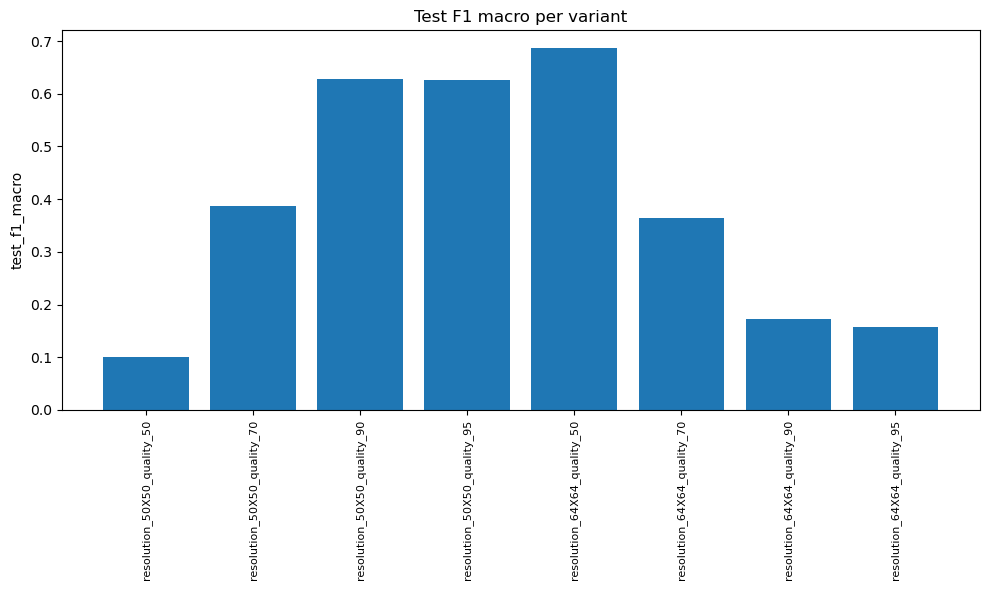

In [5]:
# quick plot of test_f1_macro
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.bar(results_df['variant'], results_df['test_f1_macro'])
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel('test_f1_macro')
    plt.title('Test F1 macro per variant')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'f1_per_variant.png')
    plt.show()
except Exception as e:
    print('Plot failed:', e)

In [ ]:
import pandas as pd
splits = pd.read_csv('models_results_2/splits_resolution_64X64_quality_70.csv')  # ajusta al archivo real
print(splits.groupby(['split','class']).size().unstack(fill_value=0))
print("Totals:", splits['split'].value_counts())